## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

import matplotlib.patches as patches

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:486: UserWarning: matplotlibrc text.usetex option can not be used unless TeX-3.1415 or later is installed on your system
  'installed on your system') % tex_req)
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:493: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.5 or later is installed on your system
  warnings.warn('matplotlibrc text.usetex can not be used with *Agg '
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:508: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-7.07 or later is installed on your system
  'installed on your system') % gs_req)


In [2]:
import spark_fof

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)

## Set up data

In [4]:
import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

import fof

In [5]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])
nps = 100
ngs = 5
particles = np.zeros(nps, dtype=pdt)
done_ps = 0
centers = np.random.rand(ngs,3)*1.8 - 0.9
for group, center in zip(range(ngs), centers): 
    group_ps = nps/ngs
    if nps - (done_ps + group_ps) < group_ps:
        group_ps = nps - done_ps 
    particles['pos'][done_ps:done_ps+group_ps] = \
        np.random.multivariate_normal(center, [[.005,0,0],[0,.005,0],[0,0,.005]], group_ps)
    done_ps += group_ps
   
particles['iOrder'] = range(nps)

## Start Spark

In [6]:
import findspark
findspark.init()

In [7]:
import pyspark
from pyspark import SparkContext, SparkConf

In [8]:
conf = SparkConf()

In [9]:
import os

In [10]:
os.environ['SPARK_DRIVER_MEMORY']= '4G'

In [11]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '5G')
conf.set('spark.driver.memory', '4G')


In [12]:
sc = SparkContext(master='local[4]', conf=conf, batchSize=0)

In [13]:
sc.addPyFile('spark_fof.py')

## Set up the domains

In [14]:
N = 4
tau = 0.05
mins = [-1,-1,-1]
maxes= [1,1,1]
domain_containers = spark_fof.setup_domain(N,tau,maxes,mins)

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


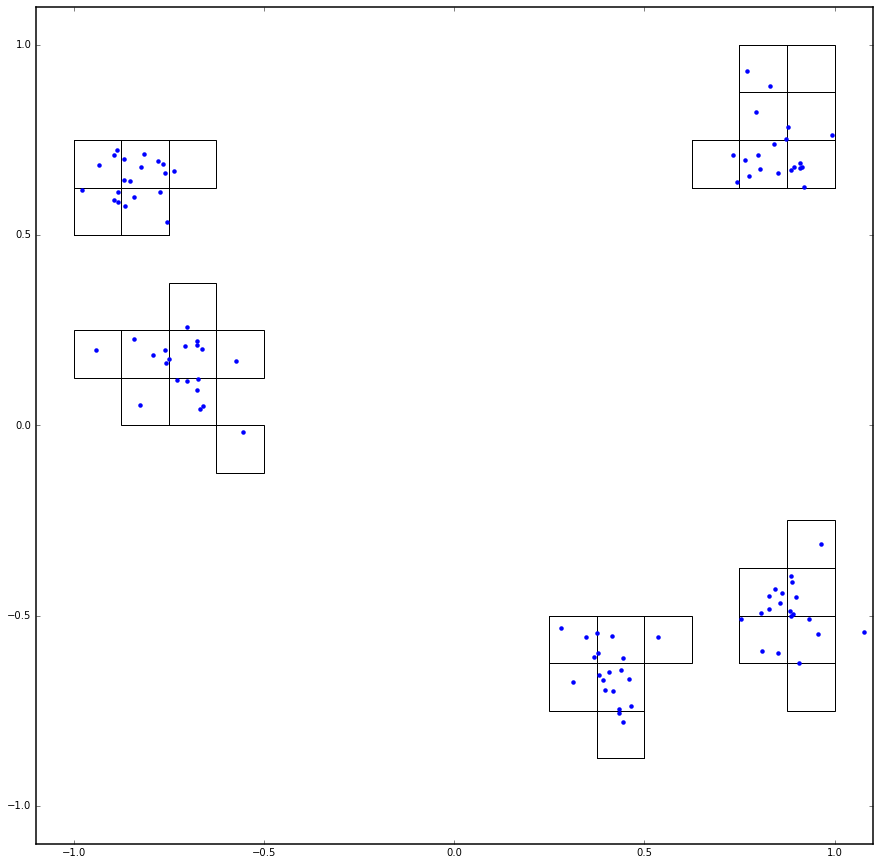

In [15]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in particles: 
    x,y,z = p['pos']
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(x, y, z,2**N, -1,-1,-1, 1,1,1)], ax=ax)
#    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)].bufferRectangle, ax=ax)
# for r in domain_containers: 
#     plot_rectangle(r.parent, ax=ax)
ax.plot(particles['pos'][:,0], particles['pos'][:,1], '.')

### Make the base RDD

In [16]:
p_rdd = sc.parallelize(particles)

In [17]:
p_rdd.collect()

[([0.3688322603702545, -0.6101234555244446, 0.6099408864974976], 0, 0),
 ([0.3120541274547577, -0.675307035446167, 0.6730671525001526], 0, 1),
 ([0.44488945603370667, -0.6110955476760864, 0.457280695438385], 0, 2),
 ([0.4138353168964386, -0.5534836649894714, 0.5893735885620117], 0, 3),
 ([0.4081345796585083, -0.6472935080528259, 0.5498375296592712], 0, 4),
 ([0.37722575664520264, -0.5980820655822754, 0.540463924407959], 0, 5),
 ([0.3915318548679352, -0.6684837937355042, 0.6530113816261292], 0, 6),
 ([0.3814866840839386, -0.6563430428504944, 0.7016027569770813], 0, 7),
 ([0.44385597109794617, -0.781044602394104, 0.6080893278121948], 0, 8),
 ([0.5353909730911255, -0.5567878484725952, 0.5920332670211792], 0, 9),
 ([0.2823551595211029, -0.5323067903518677, 0.6467645168304443], 0, 10),
 ([0.4661885201931, -0.7385273575782776, 0.5200901627540588], 0, 11),
 ([0.3469484746456146, -0.5556879043579102, 0.5175505876541138], 0, 12),
 ([0.37491780519485474, -0.5455730557441711, 0.5355561375617981],

### Partition particles into domains and set the partition part of local group ID

In [18]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers))
                 .values()).cache()

### Run the local FOF

In [19]:
from spark_util import spark_cython

In [20]:
run_fof = spark_cython('fof', 'run')

In [21]:
part_rdd.take(10)

[([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 0, 33),
 ([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 0, 33),
 ([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 0, 33),
 ([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 0, 33),
 ([0.7550281286239624, -0.5082511901855469, -0.6072574853897095], 0, 36),
 ([0.8980746865272522, -0.4500257670879364, -0.5925406813621521], 0, 21),
 ([0.8838980793952942, -0.4885076582431793, -0.6772534251213074], 0, 32),
 ([0.8838980793952942, -0.4885076582431793, -0.6772534251213074], 0, 32),
 ([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 0, 33),
 ([0.805959939956665, -0.49373817443847656, -0.6488362550735474], 0, 35)]

In [22]:
def run_local_fof(particle_iter): 
    part_arr = np.fromiter(particle_iter, pdt)
    if len(part_arr)>0:
        run_fof(part_arr, 0.1)
    return part_arr

def set_group_id(partition_index, particle_iter):
    part_arr = np.fromiter(particle_iter, pdt)
    for i in range(len(part_arr)):
        gid = part_arr[i]['iGroup']
        part_arr[i]['iGroup'] = spark_fof.encode_gid(partition_index, gid, 16)
    return part_arr

In [28]:
fof_rdd = part_rdd.mapPartitions(run_local_fof).mapPartitionsWithIndex(set_group_id)

In [27]:
parts[:10]

[([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 36569088, 33),
 ([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 36569088, 33),
 ([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 36569088, 33),
 ([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 36569088, 33),
 ([0.7550281286239624, -0.5082511901855469, -0.6072574853897095], 37552128, 36),
 ([0.8980746865272522, -0.4500257670879364, -0.5925406813621521], 37617665, 21),
 ([0.8838980793952942, -0.4885076582431793, -0.6772534251213074], 37617665, 32),
 ([0.8838980793952942, -0.4885076582431793, -0.6772534251213074], 37617665, 32),
 ([0.8505407571792603, -0.5987856388092041, -0.6478893756866455], 37617664, 33),
 ([0.805959939956665, -0.49373817443847656, -0.6488362550735474], 37617665, 35)]

### Group Merging stage

In [29]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd)

TypeError: setup_domain() takes exactly 4 arguments (2 given)

In [38]:
merged_rdd = fof_analyzer.merge_groups(0)

In [39]:
merged_rdd.collect()

[(-0.3499999940395355, -0.3499999940395355, 0, 77309411328),
 (-0.27000001072883606, -0.27000001072883606, 1, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
 (-0.1899999976158142, -0.1899999976158142, 3, 77309411328),
 (-0.009999999776482582, -0.009999999776482582, 4, 77309411328),
 (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
 (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
 (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
 (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
 (0.23000000417232513, 0.23000000417232513, 6, 77309411328),
 (0.28999999165534973, 0.28999999165534973, 7, 77309411328),
 (0.28999999165534973, 0.28999999165534973, 7, 77309411328),
 (0.28999999165534973, 0.28999999165534973, 7, 77309411328),
 (

In [40]:
sc.show_profiles()

Profile of RDD<id=26>
         2077 function calls (2013 primitive calls) in 0.007 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       44    0.001    0.000    0.002    0.000 kdtree.py:119(min_distance_point)
       64    0.001    0.000    0.005    0.000 serializers.py:259(dump_stream)
       13    0.000    0.000    0.000    0.000 {cPickle.loads}
       44    0.000    0.000    0.001    0.000 kdtree.py:15(minkowski_distance_p)
       68    0.000    0.000    0.005    0.000 spark_fof.py:258(get_buffer_particles)
       77    0.000    0.000    0.002    0.000 serializers.py:136(load_stream)
       77    0.000    0.000    0.001    0.000 serializers.py:542(read_int)
       44    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       64    0.000    0.000    0.000    0.000 serializers.py:217(load_stream)
       77    0.000    0.000    0.001    0.000 serializers.py:155(_read_with_length)

In [30]:
p_arr = np.array(fof_analyzer.particle_rdd.collect())

In [31]:
groups = np.unique(p_arr['gid'])

In [32]:
for g in groups:
    inds = np.where(p_arr['gid'] == g)
    if g in m.keys():
        p_arr['gid'][inds] = m[g]

In [33]:
p_arr

array([(-0.3499999940395355, -0.3499999940395355, 0, 77309411328),
       (-0.27000001072883606, -0.27000001072883606, 1, 77309411328),
       (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
       (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
       (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
       (-0.23000000417232513, -0.23000000417232513, 2, 77309411328),
       (-0.1899999976158142, -0.1899999976158142, 3, 77309411328),
       (-0.009999999776482582, -0.009999999776482582, 4, 77309411328),
       (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
       (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
       (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
       (0.009999999776482582, 0.009999999776482582, 5, 77309411328),
       (0.23000000417232513, 0.23000000417232513, 6, 77309411328),
       (0.28999999165534973, 0.28999999165534973, 7, 77309411328),
       (0.28999999165534973, 0.289999991

In [41]:
def remap_gid_partition(particles, gid_map):
    p_arr = np.fromiter(particles, spark_fof.pdt)
    groups = np.unique(p_arr['gid'])
    for g in groups:
        inds = np.where(p_arr['gid'] == g)
        if g in gid_map.keys():
            p_arr['gid'][inds] = gid_map[g]
    return p_arr

In [42]:
ps = fof_analyzer.particle_rdd.collect()

In [28]:
fof_analyzer.particle_rdd.collect()

[(-0.3499999940395355, -0.3499999940395355, 0, 77309411328),
 (-0.27000001072883606, -0.27000001072883606, 0, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 0, 77309411328),
 (-0.23000000417232513, -0.23000000417232513, 0, 81604378624),
 (-0.23000000417232513, -0.23000000417232513, 0, 111669149696),
 (-0.23000000417232513, -0.23000000417232513, 0, 115964116992),
 (-0.1899999976158142, -0.1899999976158142, 0, 115964116992),
 (-0.009999999776482582, -0.009999999776482582, 0, 115964116992),
 (0.009999999776482582, 0.009999999776482582, 0, 115964116992),
 (0.009999999776482582, 0.009999999776482582, 0, 120259084288),
 (0.009999999776482582, 0.009999999776482582, 0, 150323855360),
 (0.009999999776482582, 0.009999999776482582, 0, 154618822656),
 (0.23000000417232513, 0.23000000417232513, 0, 154618822656),
 (0.28999999165534973, 0.28999999165534973, 0, 154618822656),
 (0.28999999165534973, 0.28999999165534973, 0, 158913789952),
 (0.28999999165534973, 0.28999999165534973, 0, 18897

## try get_bin with cython

In [41]:
import numpy as np
# import pyximport
# pyximport.install(setup_args={"include_dirs":np.get_include()},
#                   reload_support=True)

In [42]:
xs = np.random.rand(1000000)
ys = np.random.rand(1000000)

### Setup cython on workers

looks like some helpful info here: https://www.4info.com/Blog/October-2014/Enhancing-Spark-with-IPython-Notebook-and-Cython

In [43]:
sc.addPyFile('spark_fof_c.pyx')
sc.addPyFile('spark_util.py')

In [44]:
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()})   

(None, <pyximport.pyximport.PyxImporter at 0x10ea1bed0>)

In [45]:
from spark_util import spark_cython

In [46]:
def get_particle_bin(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p.x,p.y,100,-1,-1,1,1)

def get_particle_bin_numpy(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p['x'],p['y'],100,-1,-1,1,1)

def get_particle_bin_partition(particles, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    bins = np.zeros(n, dtype=np.int32)
    
    for i, p in enumerate(particles): 
        xs[i]=p.x
        xs[i]=p.y
    
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(xs,ys,bins)
    
    for bin in bins: yield bin

def get_particle_bin_partition_numpy(particles): 
    p_arr = np.fromiter(particles, pdt)
    bins = np.zeros(len(p_arr), dtype=np.int)
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(p_arr['x'], p_arr['y'], bins)
    return bins

def get_particle_bin_python(p):
    return get_bin(p['x'],p['y'],100,[-1,-1],[1,1])

In [171]:
pdt = np.dtype([('x','f8'), ('y','f8')])

p_np_arr = np.zeros(10000000,dtype=pdt)

for i in range(len(p_np_arr)):
    p_np_arr[i] = np.random.rand(2)

In [68]:
#p_arr_rdd = sc.parallelize(p_arr).cache()
p_np_arr_rdd = sc.parallelize(p_np_arr).cache()

In [69]:
p_np_arr_rdd.count()

5000000

In [70]:
%time p_np_arr_rdd.mapPartitions(get_particle_bin_partition_numpy).count()

CPU times: user 29.7 ms, sys: 2.65 ms, total: 32.4 ms
Wall time: 1.09 s


5000000

In [71]:
sc.show_profiles()

Profile of RDD<id=38>
         10100843 function calls (10099603 primitive calls) in 3.732 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    1.305    0.326    1.786    0.447 {numpy.core.multiarray.fromiter}
  5000004    0.659    0.000    0.659    0.000 rdd.py:1004(<genexpr>)
        4    0.591    0.148    0.591    0.148 {spark_fof_c.get_particle_bins_cython}
        8    0.420    0.052    1.078    0.135 {sum}
  5000000    0.366    0.000    0.366    0.000 rdd.py:553(<lambda>)
        4    0.068    0.017    0.068    0.017 {posix.system}
     4883    0.063    0.000    0.063    0.000 {cPickle.loads}
     9774    0.030    0.000    0.030    0.000 {method 'read' of 'file' objects}
        4    0.022    0.006    0.081    0.020 Main.py:5(<module>)
        4    0.011    0.003    0.018    0.005 PyrexTypes.py:5(<module>)
      320    0.010    0.000    0.010    0.000 {imp.find_module}
       16    0.010    0.

In [125]:
import cPickle as pickle
class PickleSerializer2(pyspark.serializers.FramedSerializer):

    """
    Serializes objects using Python's pickle serializer:

        http://docs.python.org/2/library/pickle.html

    This serializer supports nearly any Python object, but may
    not be as fast as more specialized serializers.
    """

    def dumps(self, obj):
        return pickle.dumps(obj, protocol)

    if sys.version >= '3':
        def loads(self, obj, encoding="bytes"):
            return pickle.loads(obj, encoding=encoding)
    else:
        def loads(self, obj, encoding=None):
            print 'object size', len(obj)
            return pickle.loads(obj)


In [161]:
class NumpySerializer(pyspark.serializers.FramedSerializer):
    import numpy as np
    
    def __init__(self, dtype): 
        self.dtype = dtype
        super(NumpySerializer, self).__init__()
    
    def dumps(self, obj):
        print 'SERIALIZING'
        return obj.tobytes()
    def loads(self, obj):
        print 'string length: ', len(obj)
        return np.fromstring(obj, dtype=self.dtype)
    
    def _read_with_length(self, stream):
        length = pyspark.serializers.read_int(stream)
        print 'stream length: ', length
        if length == pyspark.serializers.SpecialLengths.END_OF_DATA_SECTION:
            raise EOFError
        elif length == pyspark.serializers.SpecialLengths.NULL:
            return None
        obj = stream.read(length)
        if len(obj) < length:
            raise EOFError
        return self.loads(obj)
    

In [162]:
ns = NumpySerializer(pdt)

In [163]:
new_arr_rdd = p_np_arr_rdd._reserialize(pyspark.serializers.BatchedSerializer(NumpySerializer(pdt), 1024))

In [164]:
new_arr_rdd._jrdd_deserializer

BatchedSerializer(NumpySerializer(), 1024)

In [165]:
p_np_arr_rdd._jrdd_deserializer = NumpySerializer(pdt)

In [166]:
p_np_arr_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 55.0 failed 1 times, most recent failure: Lost task 1.0 in stage 55.0 (TID 1137, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/worker.py", line 109, in main
    profiler.profile(process)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/Users/rok/miniconda/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/Users/rok/spark/python/pyspark/rdd.py", line 1004, in <lambda>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/Users/rok/spark/python/pyspark/rdd.py", line 1004, in <genexpr>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in load_stream
    yield self._read_with_length(stream)
  File "<ipython-input-161-3ca2c98f9f2e>", line 25, in _read_with_length
  File "<ipython-input-161-3ca2c98f9f2e>", line 13, in loads
ValueError: string size must be a multiple of element size

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1929)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:927)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:926)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor36.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/worker.py", line 109, in main
    profiler.profile(process)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/Users/rok/miniconda/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/Users/rok/spark/python/pyspark/rdd.py", line 1004, in <lambda>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/Users/rok/spark/python/pyspark/rdd.py", line 1004, in <genexpr>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in load_stream
    yield self._read_with_length(stream)
  File "<ipython-input-161-3ca2c98f9f2e>", line 25, in _read_with_length
  File "<ipython-input-161-3ca2c98f9f2e>", line 13, in loads
ValueError: string size must be a multiple of element size

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [172]:
%timeit pickle.dumps(p_np_arr)

1 loop, best of 3: 8.03 s per loop


In [175]:
%timeit p_np_arr.tostring()

10 loops, best of 3: 83 ms per loop


In [112]:
%time new_arr_rdd.mapPartitions(get_particle_bin_partition_numpy).count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 45.0 failed 1 times, most recent failure: Lost task 2.0 in stage 45.0 (TID 1098, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/worker.py", line 109, in main
    profiler.profile(process)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/Users/rok/miniconda/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "<ipython-input-46-70e5b75fae3f>", line 23, in get_particle_bin_partition_numpy
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in load_stream
    yield self._read_with_length(stream)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 164, in _read_with_length
    return self.loads(obj)
  File "<ipython-input-79-31f5a63a244a>", line 12, in loads
ValueError: string size must be a multiple of element size

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1929)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:927)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:926)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor36.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/worker.py", line 109, in main
    profiler.profile(process)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/profiler.py", line 160, in profile
    pr.runcall(func)
  File "/Users/rok/miniconda/lib/python2.7/cProfile.py", line 149, in runcall
    return func(*args, **kw)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/rok/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "<ipython-input-46-70e5b75fae3f>", line 23, in get_particle_bin_partition_numpy
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in load_stream
    yield self._read_with_length(stream)
  File "/Users/rok/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 164, in _read_with_length
    return self.loads(obj)
  File "<ipython-input-79-31f5a63a244a>", line 12, in loads
ValueError: string size must be a multiple of element size

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [102]:
ps = new_arr_rdd.count()

In [103]:
sc.show_profiles()

Profile of RDD<id=41>
         2008933 function calls (2008925 primitive calls) in 0.530 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1000004    0.332    0.000    0.436    0.000 rdd.py:1004(<genexpr>)
        8    0.094    0.012    0.530    0.066 {sum}
  1000000    0.077    0.000    0.077    0.000 rdd.py:553(<lambda>)
      977    0.015    0.000    0.015    0.000 {cPickle.loads}
     1958    0.007    0.000    0.007    0.000 {method 'read' of 'file' objects}
      981    0.002    0.000    0.026    0.000 serializers.py:155(_read_with_length)
      981    0.001    0.000    0.027    0.000 serializers.py:136(load_stream)
      981    0.001    0.000    0.003    0.000 serializers.py:542(read_int)
      977    0.001    0.000    0.016    0.000 serializers.py:421(loads)
      981    0.000    0.000    0.000    0.000 {_struct.unpack}
      985    0.000    0.000    0.000    0.000 {len}
        4    0.000    0.000  

In [137]:
bin(1 << 32)

'0b100000000000000000000000000000000'

In [129]:
bin(1) 

'0b1'

In [119]:
bin(101)

'0b1100101'

In [126]:
2**32

4294967296

In [140]:
x = np.binary_repr(1, width=32)

In [141]:
y = np.binary_repr(1, width=32)

In [144]:
int(x+y,2)

4294967297

In [147]:
np.binary_repr(int(x+y,2), width=64)

'0000000000000000000000000000000100000000000000000000000000000001'

In [154]:
# encode a 32-bit partition ID (pid) and 32-bit cluster ID (cid) into one 64-bit integer
encode_gid = lambda pid, cid: np.int64(int(np.binary_repr(pid,width=32)+np.binary_repr(cid,width=32),2))